In [ ]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import netCDF4 as nc
import warnings

In [19]:
all_cities = ['alicante', 'amsterdam', 'antwerp','athens', 'barcelona', 'bari', 'berlin',
            'bilbao', 'birmingham', 'bologna','bordeaux', 'brasov', 'bratislava','brussels', 'bucharest', 'budapest',
            'charleroi', 'cluj_napoca', 'cologne','copenhagen', 'debrecen','dublin', 'dusseldorf', 'edinburgh',
            'frankfurt_am_main', 'gdansk','genoa', 'ghent', 'glasgow','goteborg', 'graz', 'gyor',
            'hamburg', 'helsinki', 'klaipeda','kosice', 'krakow', 'leeds', 'leipzig','liege', 'lille', 'lisbon','ljubljana', 'lodz', 'london',
            'lyon', 'madrid','malaga', 'marseille', 'milan','miskolc', 'montpellier', 'munich','murcia', 'nantes', 'naples',
            'newcastle', 'nice',  'padua', 'palermo','palma_de_mallorca', 'paris', 'pecs',
            'porto', 'prague', 'riga', 'rome', 'rotterdam', 'sevilla',
            'sofia', 'split','stockholm', 'strasbourg', 'szeged','tallinn', 'tartu', 'thessaloniki',
            'toulouse', 'trieste','turin', 'utrecht', 'valencia','varna', 'vienna', 'vilnius',
            'warsaw', 'wroclaw', 'zagreb']
# exclude the cities that are not in Huang's mortality file
all_cities_mortality = all_cities.copy()
for city in ['alicante', 'birmingham', 'goteborg', 'lodz', 'newcastle', 'padua', 'palma_de_mallorca', 'tartu']:
    all_cities_mortality.remove(city)
# normal_cities: the cities with higher P_day than P_night        
normal_cities = []
normal_cities_long_lt, normal_cities_lat_lt = [], []
for city in all_cities_mortality:
    day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_day.txt')
    night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt')   
    if np.nansum(day_pop)>np.nansum(night_pop): ### 
        normal_cities.append(city)
        # use the coordinates of UrbClim to set location of the cities (DOI: 10.24381/cds.c6459d3a)
        file = nc.Dataset(f'C:\\Users\\glin\\Downloaded_data\\dataset-sis-urban-climate-cities\\tas_{city}_UrbClim_2015_07_v1.0.nc')
        long = np.mean([np.max(file["longitude"][:]), np.min(file["longitude"][:])])
        lat = np.mean([np.max(file["latitude"][:]), np.min(file["latitude"][:])])
        normal_cities_long_lt.append(long)
        normal_cities_lat_lt.append(lat)
        file.close()
# big_cities: the cities with higher P_day than P_night and P_night is above 1 million
big_cities = []
big_cities_long_lt, big_cities_lat_lt = [], []
for city in all_cities_mortality:
    day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_day.txt')
    night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt')   
    if (np.nansum(night_pop) > 1e6) and (np.nansum(day_pop)>np.nansum(night_pop)): ### 
        big_cities.append(city)
        file = nc.Dataset(f'C:\\Users\\glin\\Downloaded_data\\dataset-sis-urban-climate-cities\\tas_{city}_UrbClim_2015_07_v1.0.nc')
        # use the coordinates of UrbClim to set location of the cities 
        long = np.mean([np.max(file["longitude"][:]), np.min(file["longitude"][:])])
        lat = np.mean([np.max(file["latitude"][:]), np.min(file["latitude"][:])])
        big_cities_long_lt.append(long)
        big_cities_lat_lt.append(lat)
        file.close()
summer_cities = []
winter_cities = []
for city in all_cities_mortality:
    July_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt')
    Jan_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_night.txt')   
    if (np.nansum(July_pop)>np.nansum(Jan_pop)): ### 
        summer_cities.append(city)
   
def distance_rescale(population, base_pop=9645147):
    """
    Functions used in the paper
    Rescale the distance and population according to base_pop.
    base_pop=9,645,147: highest total population (daytime population in April) in Paris
    
    Arguments:
        population: 2-D numpy array of population
    Return:
        k: rescaling parameter
        rescaled_distances: 2-D
        rescaled_population: 2-D
    """
    k = (np.nansum(population)/base_pop) ** (1/3) # rescaling parameter
    # Create grid of coordinates for calculating distances
    x, y = np.meshgrid(np.arange(np.shape(population)[0]), np.arange(np.shape(population)[1]))
    # center
    x_center = (np.shape(population)[0] - 1)/2
    y_center = (np.shape(population)[0] - 1)/2
    # Calculate the distance to the city center for each grid cell
    distances = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    # rescale the distance and population according to k
    rescaled_distances = distances / k 
    rescaled_population = population / k # the location where population is Nan is still Nan in rescaled_population
    return k, rescaled_distances, rescaled_population

def monoExp(x, a, b):
    """
    Functions used in the paper
    Exponential curve used for fitting in `distance_profile
    """
    return a * np.exp(-b * x)

In [ ]:
# Figure 4 can be reproduced by the code in the 2 cells below

In [ ]:
fixed_distances = np.arange(1,30.1,0.5)
cities = big_cities # Fig 4 a,b,c
# cities = summer_cities # Fig 4 d.e.f
# DataFrame to store the results
df_day = pd.DataFrame(index=fixed_distances, columns=cities, dtype='float')
df_night =  pd.DataFrame(index=fixed_distances, columns=cities, dtype='float')
df_deltaT = pd.DataFrame(index=fixed_distances, columns=cities, dtype='float')

for city in cities:
    ## Population
    day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_day.txt')
    night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt')    
    # day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_day.txt')
    # night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_night.txt')   
    ## summer_cities or winter_cities
    # day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt')
    # night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_night.txt')
    
    k, rescaled_distances, rescaled_day_pop = distance_rescale(day_pop)
    rescaled_distances = rescaled_distances.flatten()
    rescaled_day_pop = rescaled_day_pop.flatten()
    
    k, rescaled_night_distances, rescaled_night_pop = distance_rescale(night_pop)
    rescaled_night_distances = rescaled_night_distances.flatten()
    rescaled_night_pop = rescaled_night_pop.flatten()
    
    ## Temperature
    ## summer
    down_tas_map = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_meanT_2010to12\\{city}.txt')
    ## winter
    # down_tas_map = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\Jan_meanT_2010to12\\{city}.txt')
    deltaT_map = down_tas_map - np.nanmean(down_tas_map)
    down_tas_map = down_tas_map.flatten()
    deltaT_map = deltaT_map.flatten()
    
    for i in fixed_distances:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            cond = (rescaled_night_distances >= i) & (rescaled_night_distances < i+0.5)
            df_day.loc[i, city] = np.nanmean(rescaled_day_pop[cond])
            df_night.loc[i, city] = np.nanmean(rescaled_night_pop[cond])
            df_deltaT.loc[i, city] = np.nanmean(deltaT_map[cond])

# Some cities miss a few population at certain distance range especially at shorter distances
df_day.interpolate(method='index', inplace=True)
df_night.interpolate(method='index', inplace=True)


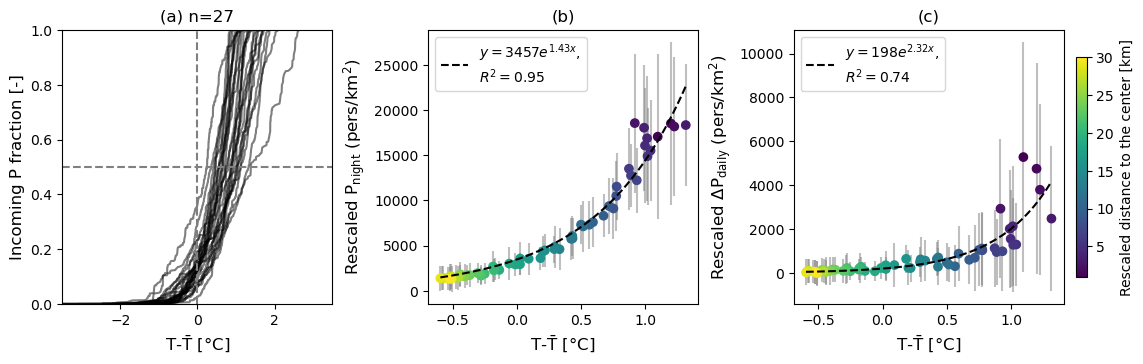

In [26]:
fig, ax= plt.subplots(1,3,figsize=(13,4))
fontsize= 12
x = np.linspace(-3.5,3.5,100)

for city in cities:
    ## daily summer
    day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_day.txt')
    night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt')   
    ## daily winter
    # day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_day.txt')
    # night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_night.txt')   
    ## seasonal
    # day_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\7\\{city}_night.txt') 
    # night_pop = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\monthly_pop_array\\1\\{city}_night.txt')  
    delta_pop = day_pop - night_pop
    ## summer exposure
    temp = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_meanT_2010to12\\{city}.txt')
    ## winter exposure
    # temp = np.loadtxt(f'C:\\Users\\glin\\Downloaded_data\\Results\\Jan_meanT_2010to12\\{city}.txt')
    
    delta_temp = temp - np.nanmean(temp)
    d = {'day_pop':day_pop.flatten(), 'night_pop':night_pop.flatten() ,'delta_pop': delta_pop.flatten(), 'temp':temp.flatten(), 'delta_temp': delta_temp.flatten()} 
    df = pd.DataFrame(data=d)
    df = df.dropna(axis=0, how='any') # drop any row which contain at least one Nan
    df = df.drop(df[df.delta_pop < 0].index) # the cumulative plot only consider locations with positive incoming population
    
    x, y = np.array(df.sort_values('delta_temp').delta_temp), np.array(df.sort_values('delta_temp').delta_pop.cumsum()/df.delta_pop.sum())
    ax[0].plot(x, y, color='k', alpha=0.5)

ax[0].set_ylim(0,1)
ax[0].set_xlim(-3.5,3.5)
ax[0].axvline(0, color='gray', linestyle='--')
ax[0].axhline(0.5, color='gray', linestyle='--')
ax[0].set_xlabel(r'T-$\rm \bar{T}$'+ ' [\N{DEGREE SIGN}C]', fontsize=fontsize)
ax[0].set_ylabel('Incoming P fraction [-]', fontsize=fontsize)
ax[0].set_title(f'(a) n={len(cities)}', fontsize=fontsize)

ax[1].scatter(np.nanmean(df_deltaT,axis=1), np.nanmean(df_night,axis=1), c=df_deltaT.index, zorder=2)
x, y = np.nanmean(df_deltaT,axis=1), np.nanmean(df_night,axis=1)
p, _ = scipy.optimize.curve_fit(monoExp, x, y)
    
# Calculate R-squared
residuals = y - monoExp(x, p[0], p[1])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

ax[1].plot(np.linspace(x.min(),x.max(),100), monoExp(np.linspace(x.min(),x.max(),100),p[0],p[1]), color='k',linestyle='--',label=fr'$y={p[0]:.0f} e^{{ {-p[1]:.2f}x }}$' + ',\n' + fr'$R^2={r_squared:.2f}$')
ax[1].set_xlabel(r'T-$\rm \bar{T}$'+' [\N{DEGREE SIGN}C]', fontsize=fontsize)
ax[1].set_ylabel('Rescaled ' r'$\rm P_{night}$'+r' $\rm (pers/km^2)$', fontsize=fontsize)
ax[1].set_title(f'(b)', fontsize=fontsize)
ax[1].legend(loc=2)

plot=ax[2].scatter(np.nanmean(df_deltaT,axis=1), np.nanmean(df_day,axis=1)-np.nanmean(df_night,axis=1), c=df_deltaT.index, zorder=2)
x, y = np.nanmean(df_deltaT,axis=1), np.nanmean(df_day,axis=1)-np.nanmean(df_night,axis=1)
p, _ = scipy.optimize.curve_fit(monoExp, x, y)


# Calculate R-squared
residuals = y - monoExp(x, p[0], p[1])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

ax[2].plot(np.linspace(x.min(),x.max(),100), monoExp(np.linspace(x.min(),x.max(),100),p[0],p[1]), color='k',linestyle='--',label=fr'$y={p[0]:.0f} e^{{ {-p[1]:.2f}x }}$' + ',\n' + fr'$R^2={r_squared:.2f}$')

# Add error bar
ax[1].errorbar(np.nanmean(df_deltaT,axis=1), np.nanmean(df_night,axis=1), yerr=np.nanstd(df_night,axis=1), fmt='none', color='gray', alpha=0.5, zorder=1)
ax[2].errorbar(np.nanmean(df_deltaT,axis=1), np.nanmean(df_day,axis=1)-np.nanmean(df_night,axis=1), np.nanstd(df_day - df_night, axis=1), fmt='none', color='gray', alpha=0.5, zorder=1)


ax[2].set_xlabel(r'T-$\rm \bar{T}$'+' [\N{DEGREE SIGN}C]', fontsize=fontsize)
## daily
ax[2].set_ylabel('Rescaled ' r'$\rm \Delta P_{daily}$'+r' $\rm (pers/km^2)$', fontsize=fontsize)
## seasonal
# ax[2].set_ylabel('Rescaled ' r'$\rm \Delta P_{seasonal}$'+r' $\rm (pers/km^2)$', fontsize=fontsize) 

ax[2].legend(loc=2)
ax[2].set_title(f'(c)', fontsize=fontsize)

plt.tight_layout(pad=2)
cbar = plt.colorbar(plot, ax=ax,label='Rescaled distance to the center [km]', shrink=0.8,pad=0.01)
